In [89]:
import pandas as pd
import numpy as np

# Set seed for reproducibility
np.random.seed(42)

# Number of records
n = 5000

# Generate Year and Department
years = np.random.choice(np.arange(2019, 2024), n)
departments = np.random.choice(["CSE", 'IT', 'MECH', 'CIVIL', 'AIDS', 'EEE', 'ECE'], n)

# Generate student count
student_count = np.random.randint(300, 900, size=n)

# Faculty count (~1 faculty per 15–25 students + noise)
faculty_count = (student_count // np.random.randint(15, 25, size=n)) + np.random.randint(-2, 3, size=n)
faculty_count = np.clip(faculty_count, 10, 60)

# Generate lab count based on department, students, faculty
lab_count = []
for dept, students, faculty in zip(departments, student_count, faculty_count):
    if dept == 'CSE':
        base, per_lab = 2, np.random.randint(100, 120)
    elif dept == 'EEE':
        base, per_lab = 3, np.random.randint(80, 100)
    elif dept == 'MECH':
        base, per_lab = 4, np.random.randint(70, 90)
    elif dept == 'ECE':
        base, per_lab = 3, np.random.randint(90, 110)
    elif dept == 'IT':
        base, per_lab = 2, np.random.randint(100, 120)
    else:  # AIDS, CIVIL
        base, per_lab = 3, np.random.randint(80, 110)

    labs = base + int(students / per_lab) + int(faculty / 20)
    lab_count.append(np.clip(labs, 2, 12))

# Total built-up area (fixed)
total_built_up_area = 63244

# Calculate total student count per department
dept_student_totals = {dept: student_count[departments == dept].sum() for dept in np.unique(departments)}

# Calculate building area based on department share
building_area = []
total_students = student_count.sum()

for dept, students in zip(departments, student_count):
    dept_area_ratio = dept_student_totals[dept] / total_students
    area_per_student = (total_built_up_area * dept_area_ratio) / dept_student_totals[dept]
    area = int(students * area_per_student + np.random.randint(500, 1500))
    building_area.append(area)

# Tuition income and prev year cost (used only to help with cost)
tuition_income = np.random.randint(1_000_000, 6_000_000, size=n)
prev_year_cost_estimate = np.random.randint(800_000, 3_000_000, size=n)

# Department-wise cost multipliers
dept_multiplier = {
    'CSE': 1.1,
    'IT': 1.1,
    'MECH': 1.2,
    'CIVIL': 1.05,
    'AIDS': 1.3,
    'EEE': 1.15,
    'ECE': 1.2
}

# Inflation based on year
inflation_rate = {
    2019: 1.00,
    2020: 1.05,
    2021: 1.10,
    2022: 1.15,
    2023: 1.20
}

# Calculate total operational cost with adjusted tuition income impact
total_cost = []
for i in range(n):
    base = (
        faculty_count[i] * 25000 +
        student_count[i] * 3500 +
        lab_count[i] * 60000 +
        building_area[i] * 120 +
        prev_year_cost_estimate[i] * 0.4 +  # Keep the previous year's cost as a factor
        np.random.normal(0, 40000)  # noise
    )
    # Adjust the tuition income impact: instead of subtracting, consider it a revenue factor
    tuition_adjustment = tuition_income[i] * 0.1  # Adjust this factor based on how much you want tuition to influence the cost
    inflation = inflation_rate[years[i]]
    dept_factor = dept_multiplier[departments[i]]
    total = int((base + tuition_adjustment) * dept_factor * inflation)  # Add tuition as a positive factor
    total_cost.append(total)

# Derive Prev_Year_Cost from total cost (simulate history)
prev_year_cost = [int(tc * np.random.uniform(0.88, 0.90)) for tc in total_cost]

# Create final DataFrame without 'Prev_Year_Cost'
df = pd.DataFrame({
    'Year': years,
    'Department': departments,
    'Faculty_Count': faculty_count,
    'Student_Count': student_count,
    'Lab_Count': lab_count,
    'Building_Area': building_area,
    'Tuition_Income': tuition_income,
    'Total_Cost': total_cost
})

# Save dataset without 'Prev_Year_Cost'
df.to_csv('realistic_college_cost_dataset.csv', index=False)

# Preview
print(df)


      Year Department  Faculty_Count  Student_Count  Lab_Count  Building_Area  \
0     2022        EEE             42            843         12            617   
1     2023        ECE             22            405          8            797   
2     2021        EEE             16            300          6            882   
3     2023         IT             51            883         11            690   
4     2023        ECE             29            731         10            857   
...    ...        ...            ...            ...        ...            ...   
4995  2022        EEE             20            367          8           1472   
4996  2022         IT             38            707          9           1038   
4997  2023         IT             50            817         11           1029   
4998  2022        EEE             24            418          8           1169   
4999  2023         IT             16            330          5            622   

      Tuition_Income  Total

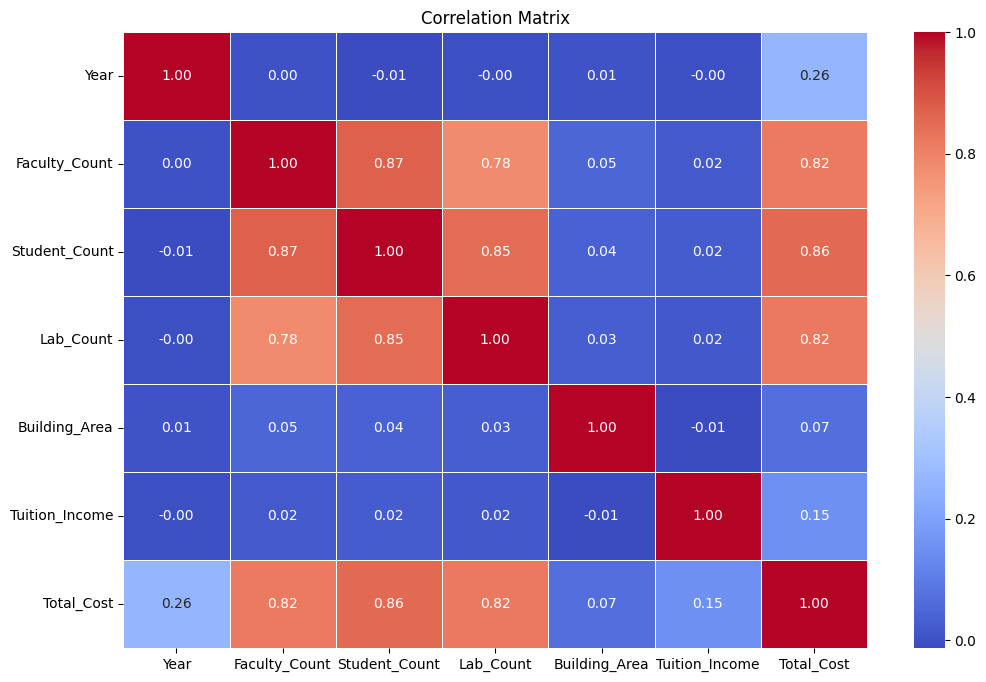

In [90]:
# Remove non-numeric columns (like 'Department') for correlation calculation
df_numeric = df.select_dtypes(include=[np.number])

# Calculate correlation matrix
correlation_matrix = df_numeric.corr()

# Plotting the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()


In [6]:
import pandas as pd
import lightgbm as lgb
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

# Load dataset
df = pd.read_csv('realistic_college_cost_dataset.csv')

# Encode Department using LabelEncoder
label_encoder = LabelEncoder()
df['Department'] = label_encoder.fit_transform(df['Department'])

# Define features and target
features = [
    'Year', 'Department', 'Faculty_Count', 'Student_Count',
    'Lab_Count', 'Building_Area', 'Tuition_Income'
]
target = 'Total_Cost'

X = df[features]
y = df[target]

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train LightGBM model
model = lgb.LGBMRegressor()
model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_test)
from math import sqrt
rmse = sqrt(mean_squared_error(y_test, y_pred))

print(f"Validation RMSE: {rmse:.2f}")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002473 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 832
[LightGBM] [Info] Number of data points in the train set: 4000, number of used features: 7
[LightGBM] [Info] Start training from score 5953759.585250
Validation RMSE: 370135.24


In [7]:
from sklearn.metrics import r2_score

# Your existing prediction
y_pred = model.predict(X_test)

# R² calculation
r2 = r2_score(y_test, y_pred)
print(f"R² Score: {r2:.4f}")


R² Score: 0.9342


In [8]:
from sklearn.model_selection import RandomizedSearchCV
import lightgbm as lgb

# Define parameter grid
param_grid = {
    'num_leaves': [31, 50, 100, 200],
    'max_depth': [-1, 5, 10, 15],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 500],
    'min_data_in_leaf': [20, 40, 60]
}

# Initialize LightGBM model
model = lgb.LGBMRegressor()

# Use RandomizedSearchCV
random_search = RandomizedSearchCV(model, param_grid, n_iter=50, cv=5, verbose=2, n_jobs=-1)
random_search.fit(X_train, y_train)

# Get the best model
best_model = random_search.best_estimator_

# Evaluate
y_pred = best_model.predict(X_test)
r2_score = r2_score(y_test, y_pred)
print(f"Tuned Model R² Score: {r2_score}")


Fitting 5 folds for each of 50 candidates, totalling 250 fits
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000356 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 832
[LightGBM] [Info] Number of data points in the train set: 4000, number of used features: 7
[LightGBM] [Info] Start training from score 5953759.585250
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

In [10]:
import pickle

# Save the tuned model to a file
with open('lgbm_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)

print("Tuned model saved successfully!")


Tuned model saved successfully!
